# Team Performance Analysis

The purpose of this notebook is to leverage our cleaned datasets 'sprint_cleaned.csv' and 'race_cleaned.csv' to answer the following questions:
- What teams perform better in the Sprint race format vs. Grand-Prix?
- How considerable is the difference between the performances across formats?
- Do the teams who excel in Sprint usually win the Grand-Prix?

### Import Data and Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sprint_filtered = pd.read_csv(r'./sprint_cleaned.csv')
race_filtered = pd.read_csv(r'./race_cleaned.csv')
constructors = pd.read_csv(r'./F1_data/constructors.csv')

### Define method to calculate team performance

In [10]:
def calculate_team_performance_delta(sprint_df, race_df):
    # Calculate average position for each constructor in both formats
    sprint_avg = sprint_df.groupby('constructorId').agg({
        'positionOrder': 'mean'
    }).rename(columns={'positionOrder': 'avg_sprint_position'})
    
    race_avg = race_df.groupby('constructorId').agg({
        'positionOrder': 'mean'
    }).rename(columns={'positionOrder': 'avg_race_position'})
    
    # Merge and calculate delta
    team_delta = pd.merge(sprint_avg, race_avg, on='constructorId', how='inner')
    team_delta['performance_delta'] = team_delta['avg_race_position'] - team_delta['avg_sprint_position']
    
    # Calculate race counts
    sprint_count = sprint_df.groupby('constructorId').size().rename('sprint_count')
    race_count = race_df.groupby('constructorId').size().rename('race_count')
    team_delta = pd.merge(team_delta, sprint_count, on='constructorId', how='left')
    team_delta = pd.merge(team_delta, race_count, on='constructorId', how='left')
    
    # Filter teams with at least 3 races in each format
    min_races = 3
    team_delta = team_delta[(team_delta['sprint_count'] >= min_races) & 
                           (team_delta['race_count'] >= min_races)]
    
    return team_delta

### Plot team performance

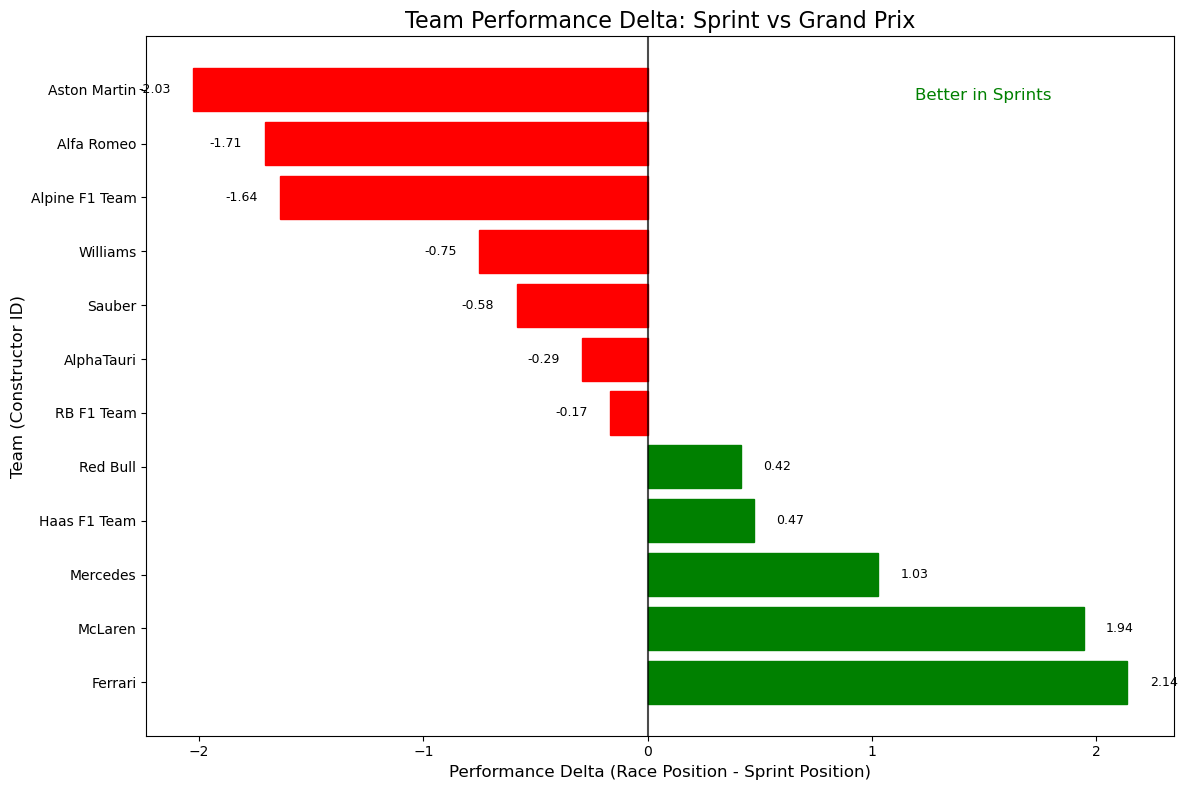

In [12]:
team_performance_delta = calculate_team_performance_delta(sprint_filtered, race_filtered)

def plot_team_performance_delta(team_delta_df):
    # Sort by delta
    sorted_df = team_delta_df.sort_values('performance_delta', ascending=False)

    sorted_df = pd.merge(sorted_df, constructors, on="constructorId", how="left")
    
    plt.figure(figsize=(12, 8))
    
    # Create horizontal bar chart
    bars = plt.barh(sorted_df['name'], sorted_df['performance_delta'], color='lightblue')
    
    # Color bars based on delta
    for i, bar in enumerate(bars):
        if sorted_df['performance_delta'].iloc[i] > 0:
            bar.set_color('green')
        else:
            bar.set_color('red')
    
    # Add vertical line at 0
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.7)
    
    # Add labels
    plt.xlabel('Performance Delta (Race Position - Sprint Position)', fontsize=12)
    plt.ylabel('Team (Constructor ID)', fontsize=12)
    plt.title('Team Performance Delta: Sprint vs Grand Prix', fontsize=16)
    
    # Add annotations
    plt.text(max(sorted_df['performance_delta']) * 0.7, len(sorted_df) * 0.9, 
             'Better in Sprints', fontsize=12, color='green', ha='center')
    plt.text(min(sorted_df['performance_delta']) * 0.7, len(sorted_df) * 0.9, 
             'Better in GPs', fontsize=12, color='red', ha='center')
    
    # Add value labels
    for i, v in enumerate(sorted_df['performance_delta']):
        plt.text(v + (0.1 if v >= 0 else -0.1), 
                 i, 
                 f"{v:.2f}", 
                 va='center',
                 ha='left' if v >= 0 else 'right',
                 fontsize=9)
    
    plt.tight_layout()
    return plt

team_plot = plot_team_performance_delta(team_performance_delta)
plt.show()

## Insights

Not surprisingly, the delta between Sprint and Grand-Prix positions does not surpass that of around 2 positions. This means that **Sprint and Grand-Prix team performance/results are fairly similar**. What's interesting to note is that Red Bull, Mercedes and McLaren (the teams who won the constructor's championship over the last 4 seasons) all have better results in Sprints races overall. With that in mind, it's fair to state that **Sprint races do have an impact on the overall constructor's championship results**.

On the other hand, Aston Martin, Alfa Romeo and Alpine show better performances in Grand-Prix when compared to Sprints. This is interesting considering that these are teams who normally don't fight for the title in the constructor's champions. Taking this into consideration, one could imply that the **points being disputed in Sprint races have higher importance to top teams**, which justifies other teams doing consistently better in the Grand-Prix.

Note: a possible addition to the analysis to support these findings could be to derive, out of the team who won the constructor's championship, how many of those points came from Sprint races. This could be an interesting exercise to further develop this hypothesis and compare the relevancy of such points across the scoreboard.